In [2]:
from collections import defaultdict, Counter
import elotl.corpus
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import statsmodels.api as sm
import os
from re import sub

In [3]:
corpusNahuatl=elotl.corpus.load('axolotl')  #español-náhuatl 
corpusOtomi=elotl.corpus.load('tsunkua')  #español-otomi 

In [4]:
def getWords(corpus):
    ### Vamos a extraer la lista de palabras para cada lengua en cada corpus: 
    corpusEs=[]
    corpusEx=[] 
    palabras=[] ### Lista temporal

    ### Iteramos sobre cada línea de los corpus y vamos guardando las palabras que corresponden a cada lengua:
    ### Corpus español-náhuatl
    for row in corpus:   
      ### row[0]: corresponde con las oraciones en español
      row[0]=sub(r'[^\w\s]',' ',row[0])     #Sustituimos signos de puntuación por un espacio
      palabras=row[0].lower().split()       #Dividimos a la oración en palabras (el delimitador es un espacio). Luego, guardamos cada una de estas palabras en la lista palabras
      for p in palabras:                    #Iteramos sobre cada palabra de la oración (lista palabras)
           corpusEs.append(p)             #vamos agregando cada palabra a una lista (corpus1_es)
      ### row[1]: corresponde con las oraciones en nahuatl   
      row[1]=sub(r'[^\w\s\']',' ',row[1])  #Sustituimo signos de puntuación por un espacio. Notemos que aparece este signo "'", también lo quitamos.
      palabras=row[1].lower().split()      #Dividimos a la oración en palabras (el delimitador es un espacio). Luego, guardamos cada una de estas palabras en la lista palabras
      for p in palabras:                      #Iteramos sobre cada palabra de la oración (lista palabras)
           corpusEx.append(p)            #vamos agregando cada palabra a una lista (corpus1_na)
    return corpusEs,corpusEx

In [29]:
palabras = getWords(corpusOtomi)
lenguajes = ["español","otomi"]

In [30]:
for i in range(2):
    print("Lenguaje: {0}".format(lenguajes[i]))
    # número de palabras totales
    print("Palabras totales: {0}".format(len(palabras[i])))
    # número de palabras distintas
    print("Palabras distintas: {0}".format(len(set(palabras[i]))))

Lenguaje: español
Palabras totales: 56893
Palabras distintas: 8712
Lenguaje: otomi
Palabras totales: 68540
Palabras distintas: 7480


In [7]:
def makeLogLogFit(xs,ys):
    xsfit = sm.add_constant(np.log(xs))
    # build model and train
    mod = sm.OLS(exog=xsfit,endog=np.log(ys))
    fit = mod.fit()
    # make list of predicted data
    ysfit = [np.exp(y) for y in fit.predict(xsfit)]
    # plotting results
    return fit, ysfit

In [8]:
def plotLogLogFit(xs,ysfit,fit,textbox=False,r1=4):
    plt.plot(xs,ysfit,label="Power law fit")
    textstr = "y = {0} x^({1}) \n R^2 = {2}".format(round(np.exp(fit.params[0]),r1),round(fit.params[1],r1),round(fit.rsquared,8))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.95,0.95, textstr,transform=plt.gca().transAxes,  fontsize=14,va='top',ha="right", bbox=props)

In [9]:
def plotLogLog(xs,ys,title,fit=True,norm=True):
    if norm:
        s = sum(ys)
        ys = [y/s for y in ys]
        plt.ylabel("Normalized Frecuency")
    else:
        plt.ylabel("Frecuency")
    plt.plot(xs,ys,label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(title)
    plt.grid()
    if fit:
        fit, ysfit = makeLogLogFit(xs,ys)
        # plotting results
        plotLogLogFit(xs,ysfit,fit)

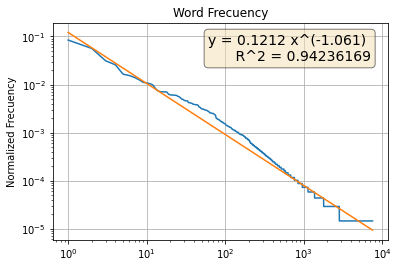

In [31]:
# plotting frecuency
counter = Counter(palabras[1])
vals = counter.most_common()
xs = range(1,len(counter.values())+1)
ys = [val[1] for val in vals]
fig = plt.figure()
plotLogLog(xs,ys,"Word Frecuency",fit=True)
plt.show()

## Building concurrency network

In [38]:
corpusNahuatl

[['Vino a iluminar el sol y allí fue a ver a su',
  'tlaminako tonati uan noponi kiitato',
  '',
  'Lo que relatan de antes (cuentos tének y nahuas de la huasteca)'],
 ['Y así  cuando hizo su ofrenda de fuego  se sienta delante de los demás y una persona se queda junto a él ',
  'Auh in ye yuhqui in on tlenamacac niman ye ic teixpan on motlalia ce tlacatl itech mocaua ',
  '',
  'Vida económica de Tenochtitlan'],
 [' Si es jade  si es oro  acaso no tendrá que ir allá ',
  ' In chalchihuitl  teocuitlatl  mach ah ca on yaz ',
  '',
  'Trece Poetas del Mundo Azteca'],
 ['Y cuando el Sol estuvo solo en el cielo  enseguida comenzó a amarillear  y fue oscureciendo poco a poco hasta que el Sol desapareció  cuando frente a él fue a colocarse la Luna  alcanzando a cubrir el disco del Sol  y así lentamente desapareció el Sol ',
  'Auh yn oyuh in yoca hualmotlalli tonatiuh ylhuicatitech  niman yc peuh yn huel ye tlacoçahuia  çan ihuiantzin ye tlayohuatiuh ynic ye poliuhtiuh tonatiuh  ynic huel ix

In [40]:
a = []
for row in corpusOtomi:
    a.append(row[2])

In [42]:
set(a)

{'Acambay, Edomex (ots)',
 'Ixtenco (otz)',
 'Otomí del Estado de México (ots)',
 'Otomí del Mezquital (ote)'}

In [32]:
concDG = nx.DiGraph()
concDG.add_nodes_from(set(palabras[1]))
concDG.add_edges_from(zip(palabras[1][1:],palabras[1][:-1]))
nx.readwrite.graphml.write_graphml(concDG,os.path.join("networks","concurrency_nah-nah.graphml"))

In [33]:
def plotDegreeDistributions(G,title,bins=20,fit=False,norm=True):
    if type(G) == nx.classes.digraph.DiGraph:
        degs = ["degree","in_degree","out_degree"]
    else:
        degs = ["degree"]
    for deg in degs:
        func = getattr(G,deg)
        degreeSequence = sorted([d for n,d in func()])
        degreeCounter = Counter(degreeSequence)
        degrees, count = zip(*degreeCounter.items())
        plt.figure()
        plotLogLog(degrees,count,"{1} \n {0} distribution".format(deg.replace("_"," "),title),fit=fit,norm=norm)
        plt.show()

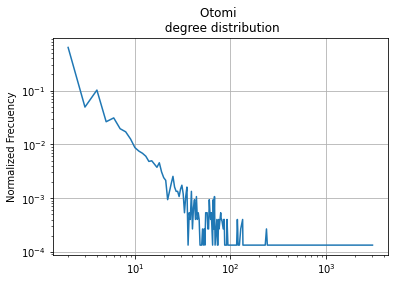

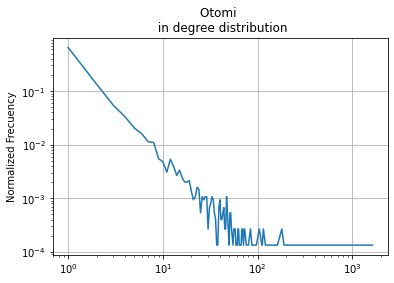

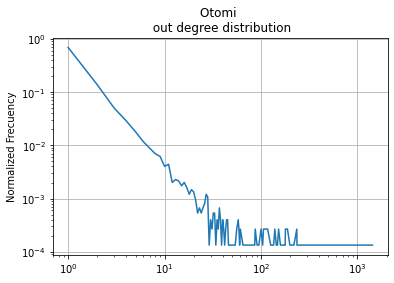

In [34]:
plotDegreeDistributions(concDG,"Otomi",fit=False,norm=True)

In [27]:
def plotBinnedDegreeDistributions(G,title,bins=20,fit=False,norm=True):
    if type(G) == nx.classes.digraph.DiGraph:
        degs = ["degree","in_degree","out_degree"]
    else:
        degs = ["degree"]
    for deg in degs:
        func = getattr(G,deg)
        degreeSequence = sorted([d for n,d in func()])
        m1 = degreeSequence[0]
        m2 = degreeSequence[-1]
        A = np.logspace(np.log10(m1),np.log10(m2),bins)
        plt.figure()
        if norm:
            weights = np.ones_like(degreeSequence) / float(len(degreeSequence))
            B = plt.hist(degreeSequence,bins=A,ec="k",weights=weights)
            plt.ylabel("Normalized frecuency")
        else: 
            B = plt.hist(degreeSequence,bins=A,ec="k")
            plt.ylabel("Frecuency")
        indexes = [i for i in range(len(A)-1) if B[0][i] > 0]
        xs = [(A[i]+A[i+1])/2 for i in indexes]
        ys = [B[0][i] for i in indexes]
        fit, ysfit = makeLogLogFit(xs,ys)
        plotLogLogFit(xs,ysfit,fit)
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Degree")
        
        plt.title("{1} \n {0} binned distribution".format(deg.replace("_"," "),title))
        plt.grid()

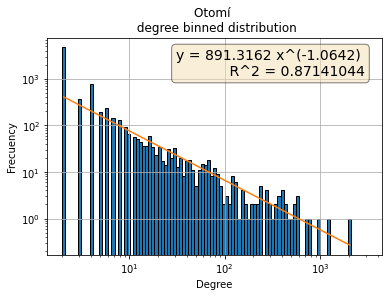

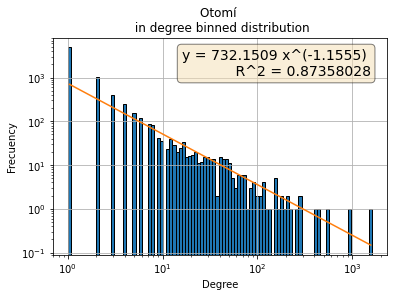

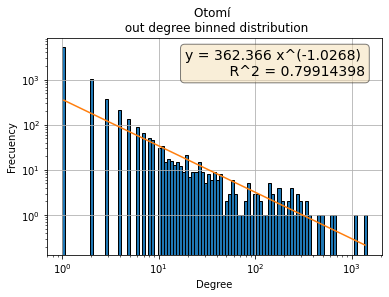

In [35]:
plotBinnedDegreeDistributions(concDG,"Otomí",bins=100,norm=False)